# 第3部　基本的な時系列予測の手法

## 第1章　単純な時系列予測の手法

### 分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error, mean_squared_error,
    mean_absolute_percentage_error, mean_absolute_error
)

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 60)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [3]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成
air_passengers.index = pd.date_range(
    start='1949-01-01', periods=len(air_passengers), freq='MS')

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

### データの分割

In [4]:
# 訓練データとテストデータに分割する
train = air_passengers.loc['1949-01':'1957-12']
test =  air_passengers.loc['1958-01':'1960-12']

### 持続予測(ナイーブ予測)

In [5]:
# 最後の観測値をテストデータの件数だけ繰り返す
naive_pred = pd.DataFrame({'value':np.tile(train.loc['1957-12-01'], 
                                           len(test))}, 
                          index=test.index)
print(naive_pred.head(3))

            value
1958-01-01    336
1958-02-01    336
1958-03-01    336


### 季節ナイーブ予測

In [6]:
# 1957年の12か月間のデータを繰り返す
s_naive_pred = pd.concat([train.loc['1957']] * 3)
s_naive_pred.index=test.index
print(s_naive_pred.head(3))

            value
1958-01-01    315
1958-02-01    301
1958-03-01    356


### 平均値予測

In [7]:
# 平均値をテストデータの件数だけ繰り返す
mean_pred = pd.DataFrame({'value':np.tile(train.mean(), len(test))}, 
                         index=test.index)
print(mean_pred.head(3))

                 value
1958-01-01  230.898148
1958-02-01  230.898148
1958-03-01  230.898148


### 移動平均法による予測

In [8]:
# 過去1年間の平均値を予測値とする
ma_pred = pd.DataFrame({'value':np.tile(train.loc['1957-1':'1957-12'].mean(), 
                                        len(test))}, 
                       index=test.index)
print(ma_pred.head(3))

                 value
1958-01-01  368.416667
1958-02-01  368.416667
1958-03-01  368.416667


### ドリフト予測

In [9]:
# 平均的なドリフト
drift = (train.loc['1957-12-01'] - train.loc['1949-01-01']) / (len(train) - 1)
drift

value    2.093458
dtype: float64

In [10]:
# ドリフトの累積和を最終時点のデータに加えることで予測値を求める
drift_pred = pd.DataFrame({
    'value':np.cumsum(np.tile(drift, len(test))) + 
            train.loc['1957-12-01'].values}, 
    index=test.index)
print(drift_pred.head(3))

                 value
1958-01-01  338.093458
1958-02-01  340.186916
1958-03-01  342.280374


### 予測手法の比較

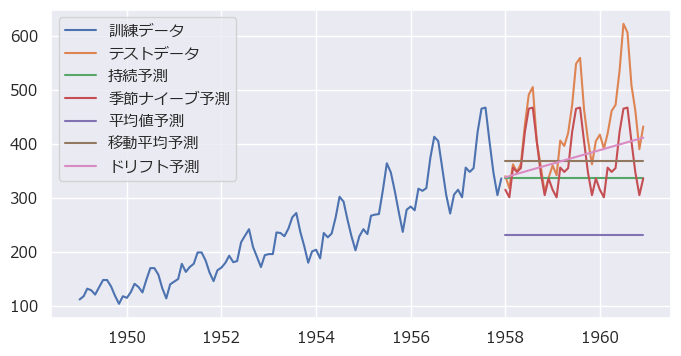

In [11]:
# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 飛行機乗客数の折れ線グラフ
ax.plot(train['value'], label='訓練データ')
ax.plot(test['value'], label='テストデータ')

# 予測値の折れ線グラフ
ax.plot(naive_pred['value'], label='持続予測')
ax.plot(s_naive_pred['value'], label='季節ナイーブ予測')
ax.plot(mean_pred['value'], label='平均値予測')
ax.plot(ma_pred['value'], label='移動平均予測')
ax.plot(drift_pred['value'], label='ドリフト予測')

# 凡例
ax.legend()

### MAE

In [12]:
np.abs(test - naive_pred).mean()

value    94.944444
dtype: float64

In [13]:
# MAE
print('持続予測　　：', mean_absolute_error(test, naive_pred))
print('季節ナイーブ：', mean_absolute_error(test, s_naive_pred))
print('平均値予測　：', mean_absolute_error(test, mean_pred))
print('移動平均予測：', mean_absolute_error(test, ma_pred))
print('ドリフト予測：', mean_absolute_error(test, drift_pred))

持続予測　　： 94.94444444444444
季節ナイーブ： 60.083333333333336
平均値予測　： 197.60185185185188
移動平均予測： 74.06018518518519
ドリフト予測： 62.84215991692627


### MSE

In [14]:
((test - naive_pred) ** 2).mean()

value    14674.555556
dtype: float64

In [15]:
# MSE
print('持続予測　　：', mean_squared_error(test, naive_pred))
print('季節ナイーブ：', mean_squared_error(test, s_naive_pred))
print('平均値予測　：', mean_squared_error(test, mean_pred))
print('移動平均予測：', mean_squared_error(test, ma_pred))
print('ドリフト予測：', mean_squared_error(test, drift_pred))

持続予測　　： 14674.555555555555
季節ナイーブ： 5418.75
平均値予測　： 45164.797410836756
移動平均予測： 9728.312499999996
ドリフト予測： 7695.698285148635


### RMSE

In [16]:
np.sqrt(((test - naive_pred)**2).mean())

value    121.13858
dtype: float64

In [17]:
# RMSE
print('持続予測　　：', np.sqrt(mean_squared_error(test, naive_pred)))
print('季節ナイーブ：', np.sqrt(mean_squared_error(test, s_naive_pred)))
print('平均値予測　：', np.sqrt(mean_squared_error(test, mean_pred)))
print('移動平均予測：', np.sqrt(mean_squared_error(test, ma_pred)))
print('ドリフト予測：', np.sqrt(mean_squared_error(test, drift_pred)))

持続予測　　： 121.13857996342682
季節ナイーブ： 73.61215932167728
平均値予測　： 212.52011060329505
移動平均予測： 98.63220822834697
ドリフト予測： 87.7251291543571


### MAPE

In [18]:
(np.abs(test - naive_pred) / test).mean()

value    0.198867
dtype: float64

In [19]:
# MAPE
print('持続予測　　：', mean_absolute_percentage_error(test, naive_pred))
print('季節ナイーブ：', mean_absolute_percentage_error(test, s_naive_pred))
print('平均値予測　：', mean_absolute_percentage_error(test, mean_pred))
print('移動平均予測：', mean_absolute_percentage_error(test, ma_pred))
print('ドリフト予測：', mean_absolute_percentage_error(test, drift_pred))

持続予測　　： 0.19886711926999853
季節ナイーブ： 0.13189432350948402
平均値予測　： 0.4441010032912314
移動平均予測： 0.15522265083435094
ドリフト予測： 0.12990464190138912


### MASE

In [20]:
# 訓練データにおける持続予測の1期先予測誤差
naive_error = np.abs(train['1949-02':'1957-12'].values - 
                     train['1949-01':'1957-11'].values).mean()
naive_error

20.317757009345794

In [21]:
# MASE
(np.abs(test - naive_pred) / naive_error).mean()

value    4.672979
dtype: float64

In [22]:
# MASE
print('持続予測　　：', mean_absolute_scaled_error(test, naive_pred, 
                                            y_train=train))
print('季節ナイーブ：', mean_absolute_scaled_error(test, s_naive_pred, 
                                            y_train=train))
print('平均値予測　：', mean_absolute_scaled_error(test, mean_pred, 
                                            y_train=train))
print('移動平均予測：', mean_absolute_scaled_error(test, ma_pred, 
                                            y_train=train))
print('ドリフト予測：', mean_absolute_scaled_error(test, drift_pred, 
                                            y_train=train))

持続予測　　： 4.672978636410099
季節ナイーブ： 2.9571833793314934
平均値予測　： 9.725574125183142
移動平均予測： 3.645096510954377
ドリフト予測： 3.0929673924154146
